# FD003

In [1]:
!wget https://ti.arc.nasa.gov/c/6/ -O data.zip
!unzip data.zip
!pip install lifelines

--2021-04-30 16:52:24--  https://ti.arc.nasa.gov/c/6/
Resolving ti.arc.nasa.gov (ti.arc.nasa.gov)... 128.102.105.66, 2001:4d0:6311:2227:14b6:372b:2078:2a94
Connecting to ti.arc.nasa.gov (ti.arc.nasa.gov)|128.102.105.66|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://ti.arc.nasa.gov/m/project/prognostic-repository/CMAPSSData.zip [following]
--2021-04-30 16:52:25--  https://ti.arc.nasa.gov/m/project/prognostic-repository/CMAPSSData.zip
Reusing existing connection to ti.arc.nasa.gov:443.
HTTP request sent, awaiting response... 200 OK
Length: 12425978 (12M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  11.85M  4.81MB/s    in 2.5s    

2021-04-30 16:52:27 (4.81 MB/s) - ‘data.zip’ saved [12425978/12425978]

Archive:  data.zip
  inflating: Damage Propagation Modeling.pdf  
  inflating: readme.txt              
  inflating: RUL_FD001.txt           
  inflating: RUL_FD002.txt           
  inflating: RUL_FD003.txt 

In [2]:
# load necessary packages
import os
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from tqdm.notebook import trange
from IPython.display import display, HTML
from sklearn.metrics import mean_squared_error, r2_score
from lifelines import KaplanMeierFitter, CoxTimeVaryingFitter
%matplotlib inline

In [3]:
inputdir = ""

#seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0

# Preparing datasets

In [4]:
# the files did not contain headers. Here we create labels based on documentation
index_columns_names =  ["UnitNumber","Cycle"]
op_settings_columns = ["Op_Setting_"+str(i) for i in range(1,4)]
sensor_columns =["Sensor_"+str(i) for i in range(1,22)]
na_columns = ["NA1", "NA2"]
column_names = index_columns_names + op_settings_columns + sensor_columns + na_columns

# load data
df_train= pd.read_csv(inputdir+'train_FD003.txt', sep=" ", header=None, names = column_names)
df_test = pd.read_csv(inputdir+'test_FD003.txt', sep=" ", header=None, names = column_names)

# drop NULL columns
df_train.drop(df_train.columns[[26, 27]], axis=1, inplace=True)
df_test.drop(df_test.columns[[26, 27]], axis=1, inplace=True)

display(df_train)

,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,Sensor_6,Sensor_7,Sensor_8,Sensor_9,Sensor_10,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,21.61,553.97,2387.96,9062.17,1.3,47.30,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,21.61,554.55,2388.00,9061.78,1.3,47.23,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,21.61,554.43,2388.03,9070.23,1.3,47.22,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,21.61,555.21,2388.00,9064.57,1.3,47.24,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,21.61,554.74,2388.04,9076.14,1.3,47.15,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24715,100,148,-0.0016,-0.0003,100.0,518.67,643.78,1596.01,1424.11,14.62,21.61,551.86,2388.25,9070.82,1.3,48.27,519.66,2388.30,8138.08,8.5036,0.03,394,2388,100.0,38.44,22.9631
24716,100,149,0.0034,-0.0003,100.0,518.67,643.29,1596.38,1429.14,14.62,21.61,551.86,2388.23,9064.60,1.3,48.13,519.91,2388.28,8144.36,8.5174,0.03,395,2388,100.0,38.50,22.9746
24717,100,150,-0.0016,0.0004,100.0,518.67,643.84,1604.53,1431.41,14.62,21.61,551.30,2388.25,9063.45,1.3,48.18,519.44,2388.24,8135.95,8.5223,0.03,396,2388,100.0,38.39,23.0682
24718,100,151,-0.0023,0.0004,100.0,518.67,643.94,1597.56,1426.57,14.62,21.61,550.69,2388.26,9062.22,1.3,48.05,520.01,2388.26,8141.24,8.5148,0.03,395,2388,100.0,38.31,23.0753


# Adding Failure indicators and Cycle starts

In [5]:
df_train["IsFailure"] = 0
idx_failure = (np.where(df_train["Cycle"] ==1)[0] - 1)[1:]
df_train["IsFailure"][idx_failure] = 1
df_train["CycleStart"] = df_train["Cycle"]-1
df_train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,Sensor_6,Sensor_7,Sensor_8,Sensor_9,Sensor_10,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21,IsFailure,CycleStart
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,21.61,553.97,2387.96,9062.17,1.3,47.30,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,0,0
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,21.61,554.55,2388.00,9061.78,1.3,47.23,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,0,1
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,21.61,554.43,2388.03,9070.23,1.3,47.22,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,0,2
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,21.61,555.21,2388.00,9064.57,1.3,47.24,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,0,3
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,21.61,554.74,2388.04,9076.14,1.3,47.15,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24715,100,148,-0.0016,-0.0003,100.0,518.67,643.78,1596.01,1424.11,14.62,21.61,551.86,2388.25,9070.82,1.3,48.27,519.66,2388.30,8138.08,8.5036,0.03,394,2388,100.0,38.44,22.9631,0,147
24716,100,149,0.0034,-0.0003,100.0,518.67,643.29,1596.38,1429.14,14.62,21.61,551.86,2388.23,9064.60,1.3,48.13,519.91,2388.28,8144.36,8.5174,0.03,395,2388,100.0,38.50,22.9746,0,148
24717,100,150,-0.0016,0.0004,100.0,518.67,643.84,1604.53,1431.41,14.62,21.61,551.30,2388.25,9063.45,1.3,48.18,519.44,2388.24,8135.95,8.5223,0.03,396,2388,100.0,38.39,23.0682,0,149
24718,100,151,-0.0023,0.0004,100.0,518.67,643.94,1597.56,1426.57,14.62,21.61,550.69,2388.26,9062.22,1.3,48.05,520.01,2388.26,8141.24,8.5148,0.03,395,2388,100.0,38.31,23.0753,0,150


In [6]:
drop_sensors = op_settings_columns +['Sensor_1','Sensor_5','Sensor_6','Sensor_10','Sensor_16','Sensor_18','Sensor_19']
X = df_train.drop(labels=drop_sensors, axis=1)
X

,UnitNumber,Cycle,Sensor_2,Sensor_3,Sensor_4,Sensor_7,Sensor_8,Sensor_9,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_17,Sensor_20,Sensor_21,IsFailure,CycleStart
0,1,1,642.36,1583.23,1396.84,553.97,2387.96,9062.17,47.30,522.31,2388.01,8145.32,8.4246,391,39.11,23.3537,0,0
1,1,2,642.50,1584.69,1396.89,554.55,2388.00,9061.78,47.23,522.42,2388.03,8152.85,8.4403,392,38.99,23.4491,0,1
2,1,3,642.18,1582.35,1405.61,554.43,2388.03,9070.23,47.22,522.03,2388.00,8150.17,8.3901,391,38.85,23.3669,0,2
3,1,4,642.92,1585.61,1392.27,555.21,2388.00,9064.57,47.24,522.49,2388.08,8146.56,8.3878,392,38.96,23.2951,0,3
4,1,5,641.68,1588.63,1397.65,554.74,2388.04,9076.14,47.15,522.58,2388.03,8147.80,8.3869,392,39.14,23.4583,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24715,100,148,643.78,1596.01,1424.11,551.86,2388.25,9070.82,48.27,519.66,2388.30,8138.08,8.5036,394,38.44,22.9631,0,147
24716,100,149,643.29,1596.38,1429.14,551.86,2388.23,9064.60,48.13,519.91,2388.28,8144.36,8.5174,395,38.50,22.9746,0,148
24717,100,150,643.84,1604.53,1431.41,551.30,2388.25,9063.45,48.18,519.44,2388.24,8135.95,8.5223,396,38.39,23.0682,0,149
24718,100,151,643.94,1597.56,1426.57,550.69,2388.26,9062.22,48.05,520.01,2388.26,8141.24,8.5148,395,38.31,23.0753,0,150


In [7]:
df_test["IsFailure"] = 0
idx_failure = (np.where(df_test["Cycle"] ==1)[0] - 1)[1:]
df_test["IsFailure"][idx_failure] = 1
df_test["CycleStart"] = df_test["Cycle"]-1
X_test = df_test[X.columns]
X_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,UnitNumber,Cycle,Sensor_2,Sensor_3,Sensor_4,Sensor_7,Sensor_8,Sensor_9,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_17,Sensor_20,Sensor_21,IsFailure,CycleStart
0,1,1,641.94,1581.93,1396.93,554.56,2387.93,9048.65,47.09,521.89,2387.94,8133.48,8.3760,391,39.07,23.4468,0,0
1,1,2,642.02,1584.86,1398.90,554.10,2387.94,9046.53,47.08,521.85,2388.01,8137.44,8.4062,391,39.04,23.4807,0,1
2,1,3,641.68,1581.78,1391.92,554.41,2387.97,9054.92,47.15,522.10,2387.94,8138.25,8.3553,391,39.10,23.4244,0,2
3,1,4,642.20,1584.53,1395.34,554.58,2387.94,9055.04,47.26,522.45,2387.96,8137.07,8.3709,392,38.97,23.4782,0,3
4,1,5,642.46,1589.03,1395.86,554.16,2388.01,9048.59,46.94,521.91,2387.97,8134.20,8.4146,391,39.09,23.3950,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16591,100,243,643.04,1594.99,1411.28,561.21,2388.24,9088.31,47.61,529.23,2388.24,8162.24,8.2939,395,39.40,23.4949,0,242
16592,100,244,642.47,1591.27,1417.64,561.02,2388.29,9085.35,47.75,529.27,2388.26,8163.24,8.3247,394,39.42,23.6011,0,243
16593,100,245,642.70,1593.81,1412.70,561.16,2388.23,9084.29,47.60,529.48,2388.28,8162.12,8.3264,394,39.43,23.5482,0,244
16594,100,246,642.19,1595.63,1406.58,562.66,2388.24,9092.52,47.69,529.39,2388.33,8164.20,8.2908,395,39.40,23.6687,0,245


In [8]:
from lifelines import CoxPHFitter
cph = CoxTimeVaryingFitter()

cph.fit(X, id_col='UnitNumber', event_col='IsFailure', start_col='CycleStart', stop_col='Cycle')
cph.print_summary() 

<lifelines.CoxTimeVaryingFitter: fitted with 24720 periods, 100 subjects, 99 events>
         event col = 'IsFailure'
number of subjects = 100
 number of periods = 24720
  number of events = 99
partial log-likelihood = -77.43
  time fit was run = 2021-04-30 16:52:36 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Sensor_2    1.27       3.56       0.49             0.32             2.22                 1.37                 9.24
Sensor_3    0.10       1.10       0.04             0.02             0.17                 1.02                 1.19
Sensor_4    0.19       1.21       0.04             0.11             0.28                 1.11                 1.32
Sensor_7    0.05       1.05       0.33            -0.59             0.69                 0.55                 2.00
Sensor_8    3.23      25.20       4.87            -6.33            12.78                 0.00             3.55e+05
Sensor_9    0.03       1.03       0.04            -0.04             0.10                 0.96                 1.10
Sensor_11  10.73   45644.47       1.87             7.06            14.40              1160.96             1.79e+06
Sensor_12   0.05       1.05       0.40            -0.74             0.83                 0.48                 2.30
Sensor_13   7.95    2848.93       5.04            -1.92            17.83                 0.15             5.56e+07
Sensor_14  -0.02       0.98       0.04            -0.09             0.06                 0.91                 1.06
Sensor_15  -0.94       0.39       8.65           -17.90            16.01                 0.00             9.01e+06
Sensor_17   0.38       1.46       0.18             0.03             0.73                 1.03                 2.07
Sensor_20  -1.71       0.18       1.63            -4.91             1.50                 0.01                 4.46
Sensor_21  -1.60       0.20       2.45            -6.41             3.21                 0.00                24.80

              z      p   -log2(p)
covariate                        
Sensor_2   2.61   0.01       6.79
Sensor_3   2.48   0.01       6.25
Sensor_4   4.41 <0.005      16.57
Sensor_7   0.15   0.88       0.19
Sensor_8   0.66   0.51       0.98
Sensor_9   0.83   0.41       1.29
Sensor_11  5.73 <0.005      26.54
Sensor_12  0.12   0.91       0.14
Sensor_13  1.58   0.11       3.13
Sensor_14 -0.39   0.69       0.53
Sensor_15 -0.11   0.91       0.13
Sensor_17  2.14   0.03       4.95
Sensor_20 -1.04   0.30       1.76
Sensor_21 -0.65   0.51       0.96
---
Partial AIC = 182.87
log-likelihood ratio test = 563.44 on 14 df
-log2(p) of ll-ratio test = 367.07

In [9]:
#prediction
pred_cols = ['Cycle',
 'Sensor_2',
 'Sensor_3',
 'Sensor_4',
 'Sensor_7',
 'Sensor_8',
 'Sensor_9',
 'Sensor_11',
 'Sensor_12',
 'Sensor_13',
 'Sensor_14',
 'Sensor_15',
 'Sensor_17',
 'Sensor_20',
 'Sensor_21',
 'IsFailure',
 'CycleStart']

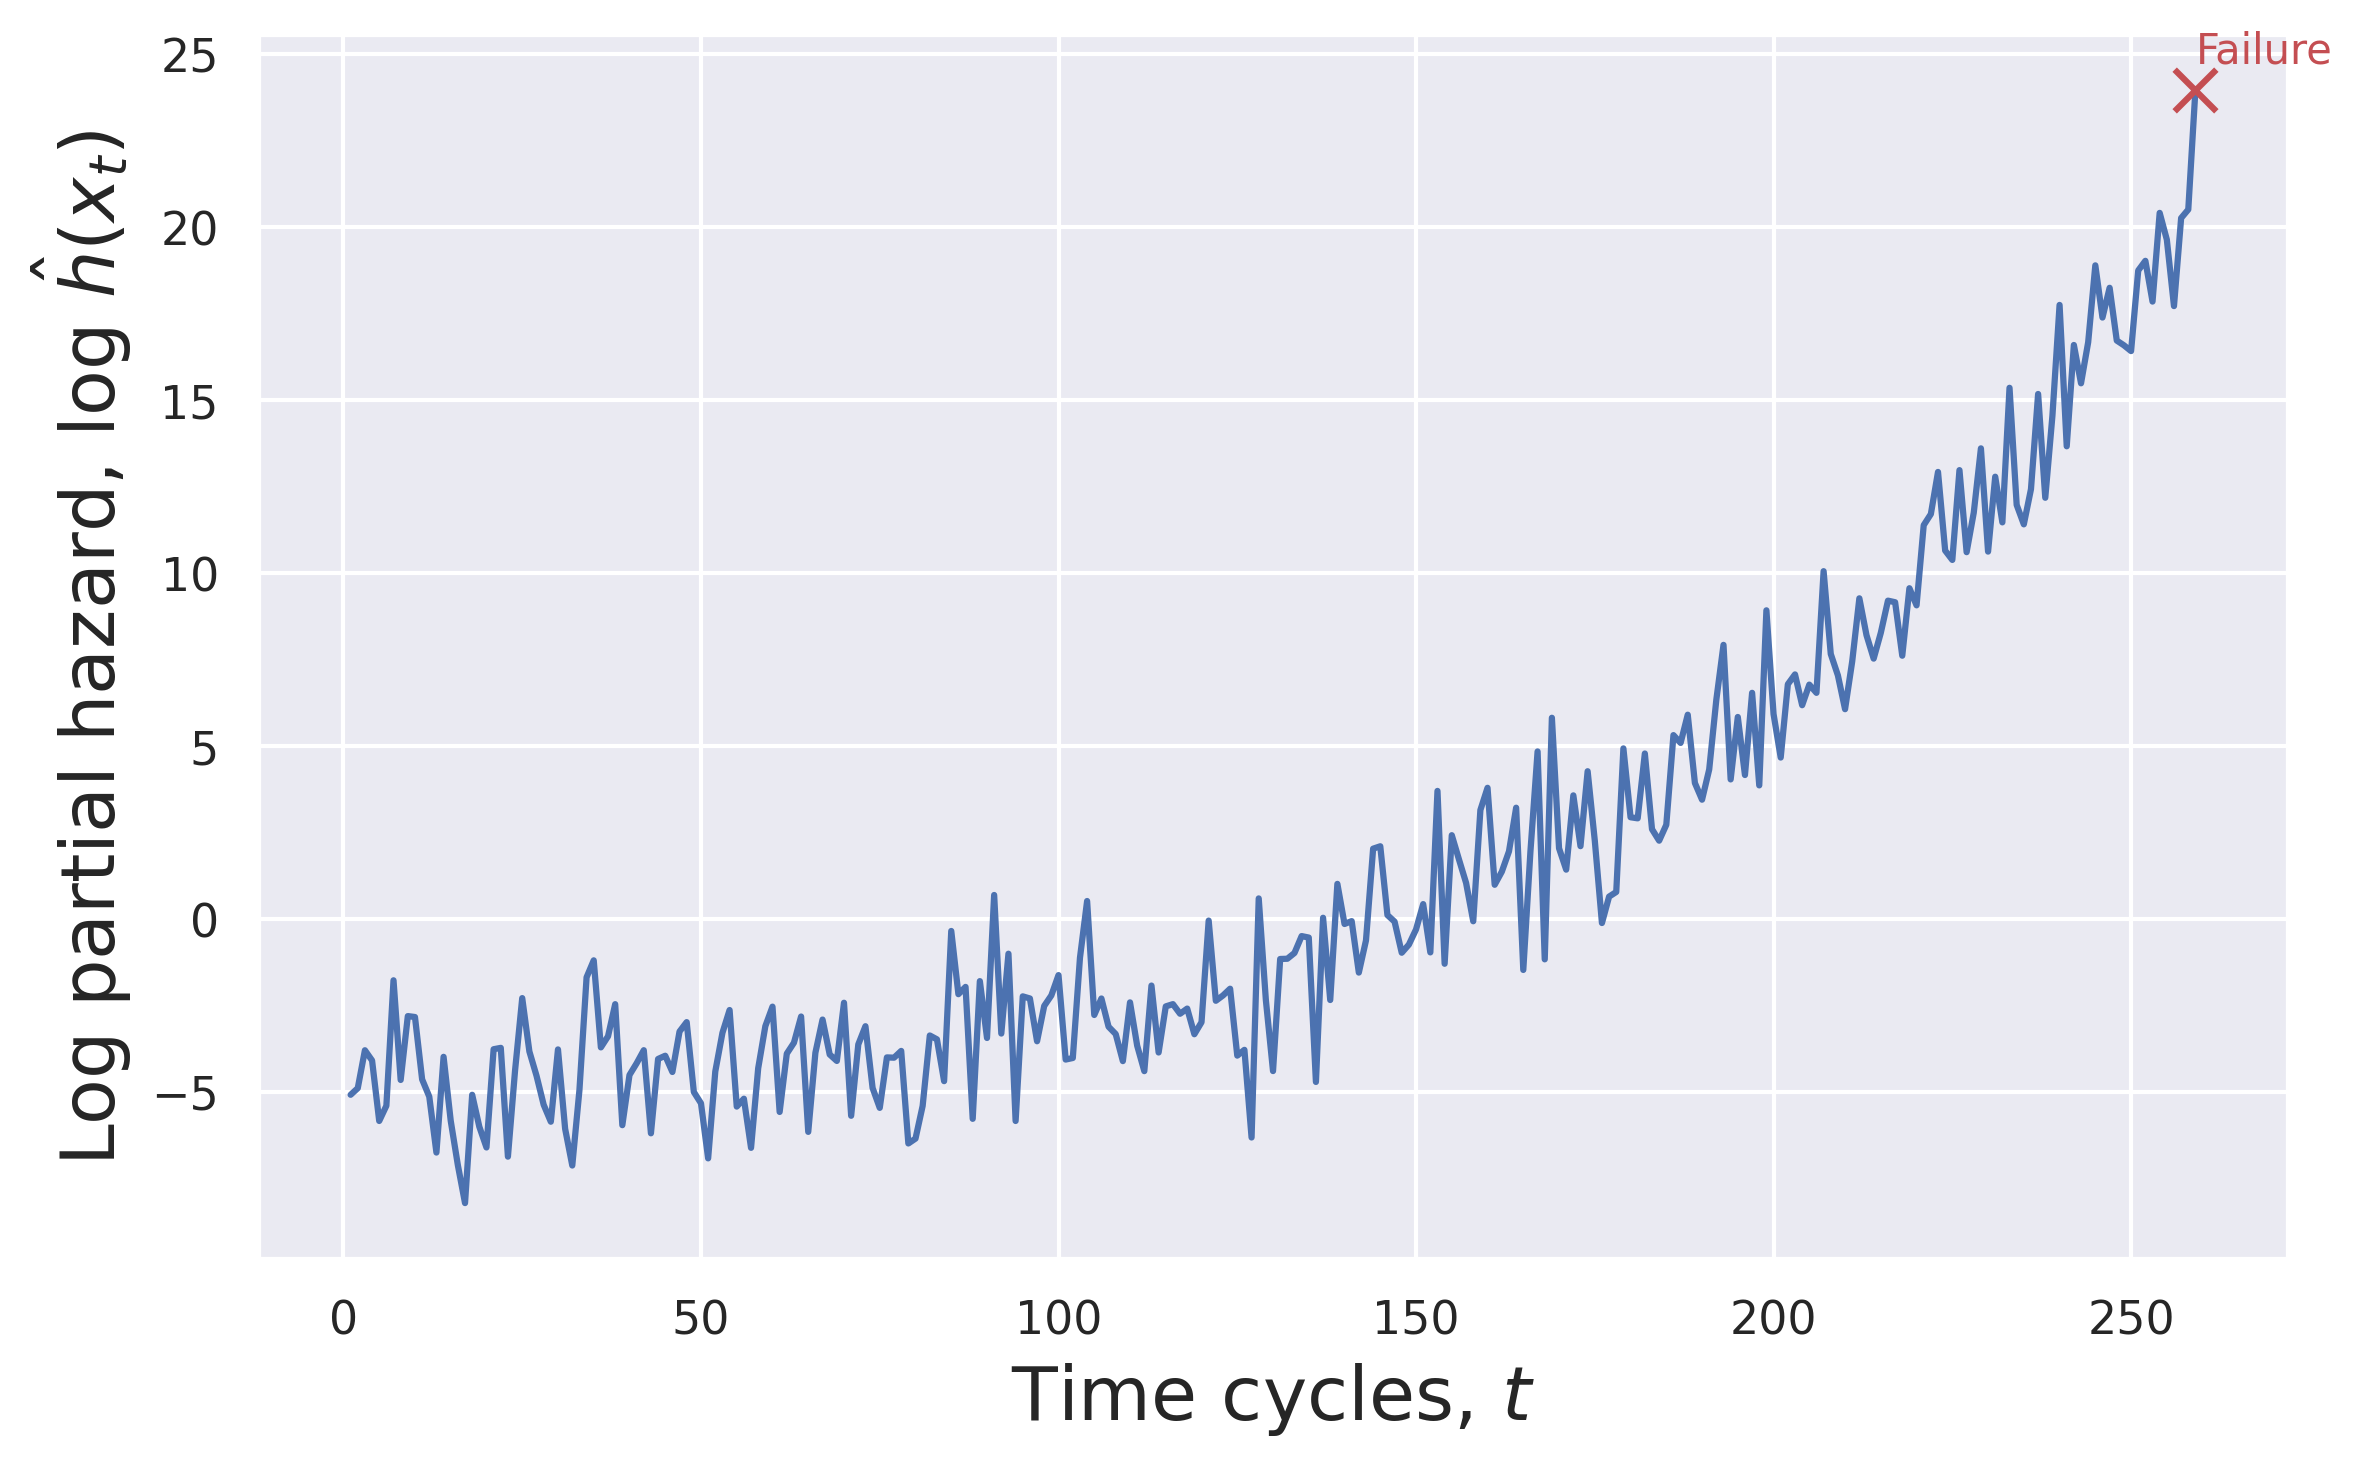

In [10]:
plt.figure(figsize=(8,5), dpi=300)


X_sub = X.loc[X['UnitNumber'] == 1]
predictions = cph.predict_partial_hazard(X_sub[pred_cols])
plt.plot(X_sub['Cycle'].values, np.log(predictions))
plt.scatter(np.array(X_sub['Cycle'].values)[-1], np.log(predictions).values[-1], s=100, marker="x", zorder=10, c="C3")
plt.text(np.array(X_sub['Cycle'].values)[-1], np.log(predictions).values[-1]+0.8, "Failure", c="C3", fontsize=10)

plt.xlabel('Time cycles, $t$', fontsize=18)
plt.ylabel('Log partial hazard, $\log ~\hat{h}(x_t)$', fontsize=18)
plt.tight_layout()
plt.savefig('fd003_hazard_traj.pdf', format="pdf")
plt.show()
  

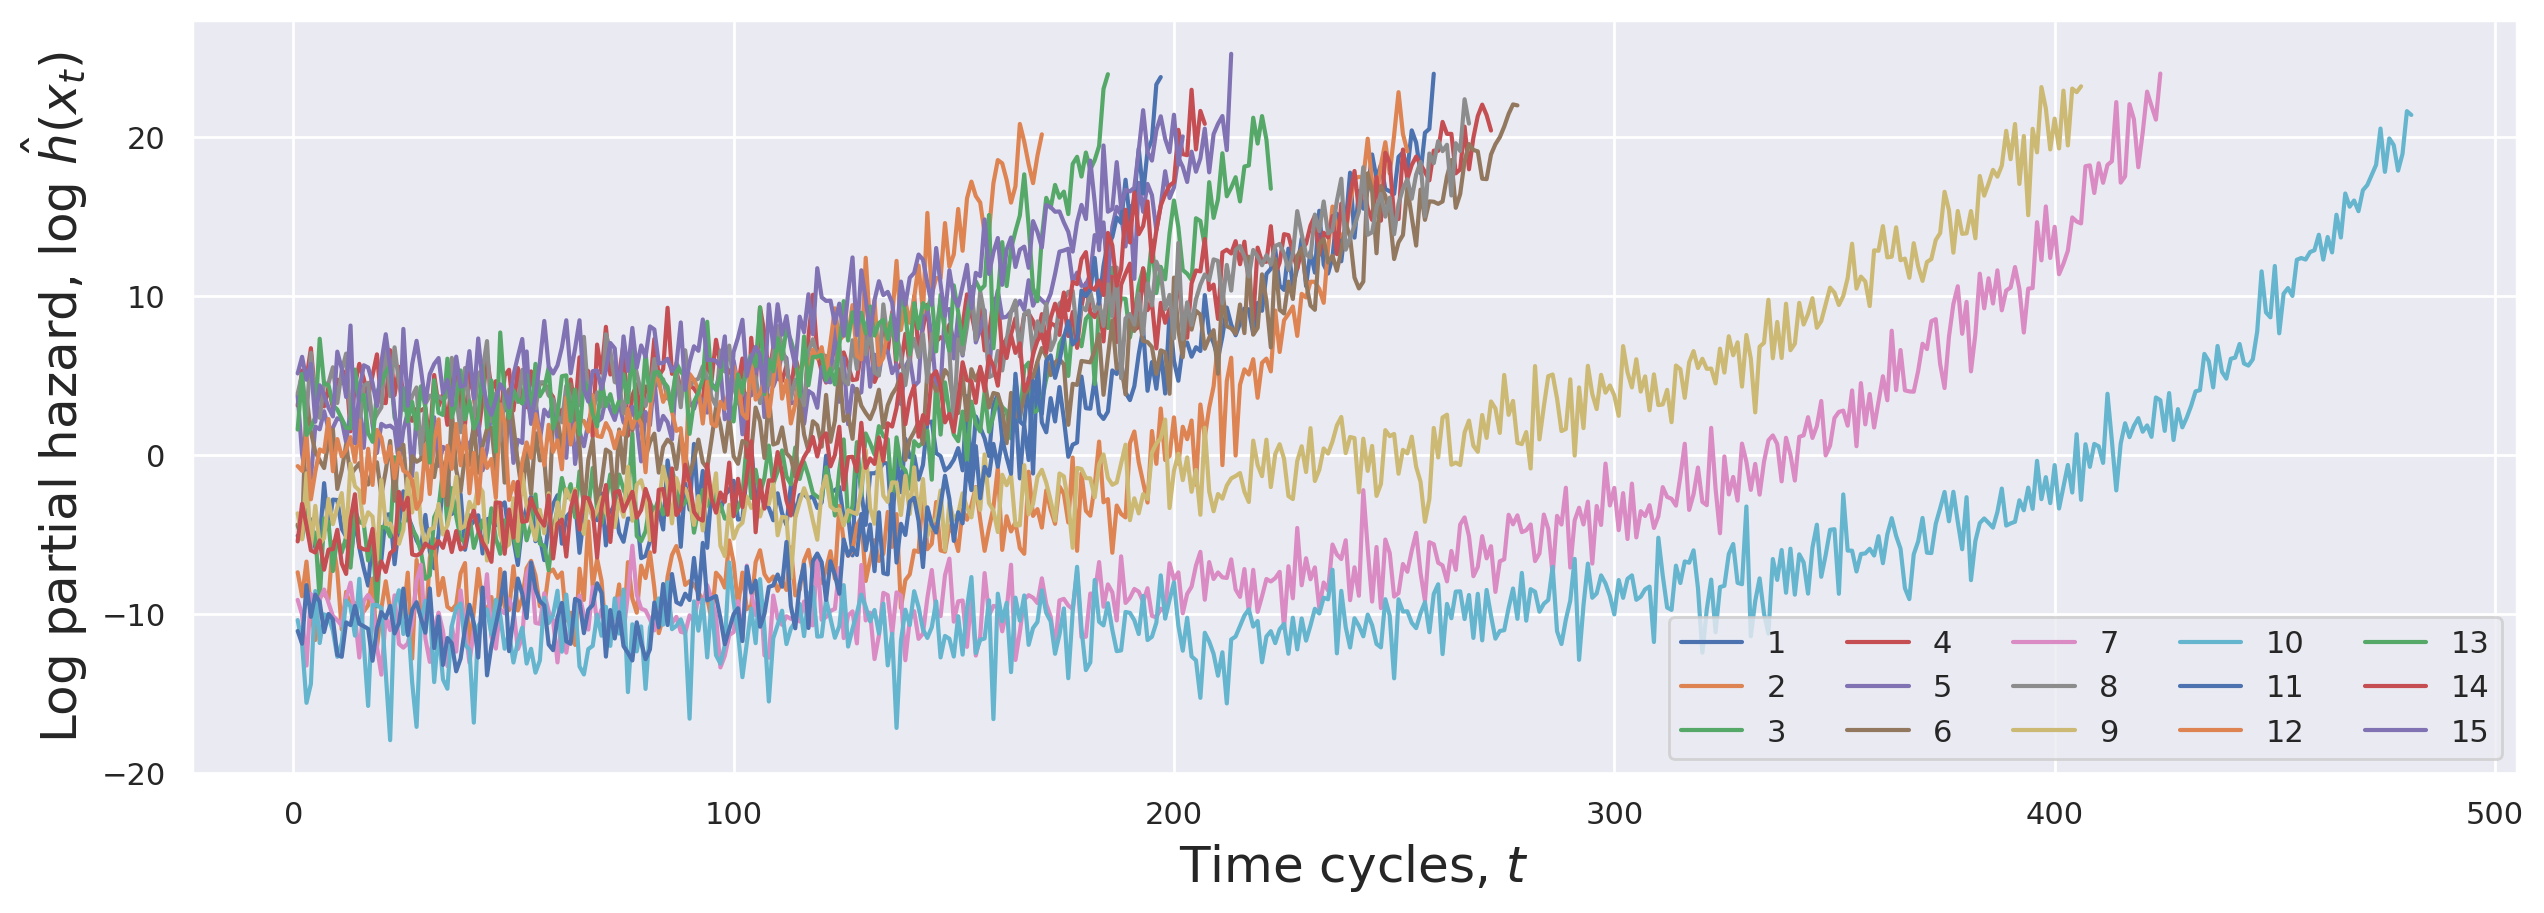

In [11]:
plt.figure(figsize=(15,5), dpi=200)

for i in trange(15):
    X_sub = X.loc[X['UnitNumber'] == i+1]
    predictions = cph.predict_partial_hazard(X_sub[pred_cols])
    plt.plot(X_sub['Cycle'].values, np.log(predictions), label=i+1)

plt.xlabel('Time cycles, $t$', fontsize=18)
plt.ylabel('Log partial hazard, $\log ~\hat{h}(x_t)$', fontsize=18)
plt.legend(ncol=5)
#plt.ylim([10, None])
plt.show()


# Thresholding the hazard score for decision making


In [12]:
#training

llp_replacement=4000000
perf_restoration=3500000

thres_list  = np.arange(18, 28, 1)


rep_num= 10
machine_num = 30

optim_data_mean = []
optim_data_std = []
for thres in thres_list :
  #simulate for rep_num times
  sim_results = []
  for k in trange(rep_num):
    #in each rep select machine_num machines
    machines = np.random.choice(X['UnitNumber'].unique(), size=machine_num)    
    machine_i = []
    for i in range(machine_num):
      X_sub = X.loc[X['UnitNumber'] == machines[i]]
      X_fail = X.loc[X['UnitNumber'] == machines[i]]['IsFailure']      
      predictions = cph.predict_partial_hazard(X_sub[pred_cols])

      m_maint = np.log(predictions) > thres 
      
      total_perf_rest = (m_maint.sum()>1) * perf_restoration      
      is_failed = m_maint.sum()==0
      total_llp_rep = is_failed*llp_replacement      
      total_maintcost = total_perf_rest + total_llp_rep
      
      machine_i.append([is_failed, total_perf_rest, total_llp_rep, total_maintcost])

    machine_i = np.array(machine_i)
    sim_result = [thres, machine_i[:, 0].mean(),  machine_i[:, 1].sum(),  
                  machine_i[:, 2].sum(),  machine_i[:, 3].sum()]
                  

    sim_results.append(sim_result)

  sim_results = np.array(sim_results)
  optim_data_mean.append(sim_results.mean(axis=0))
  optim_data_std.append(sim_results.std(axis=0))

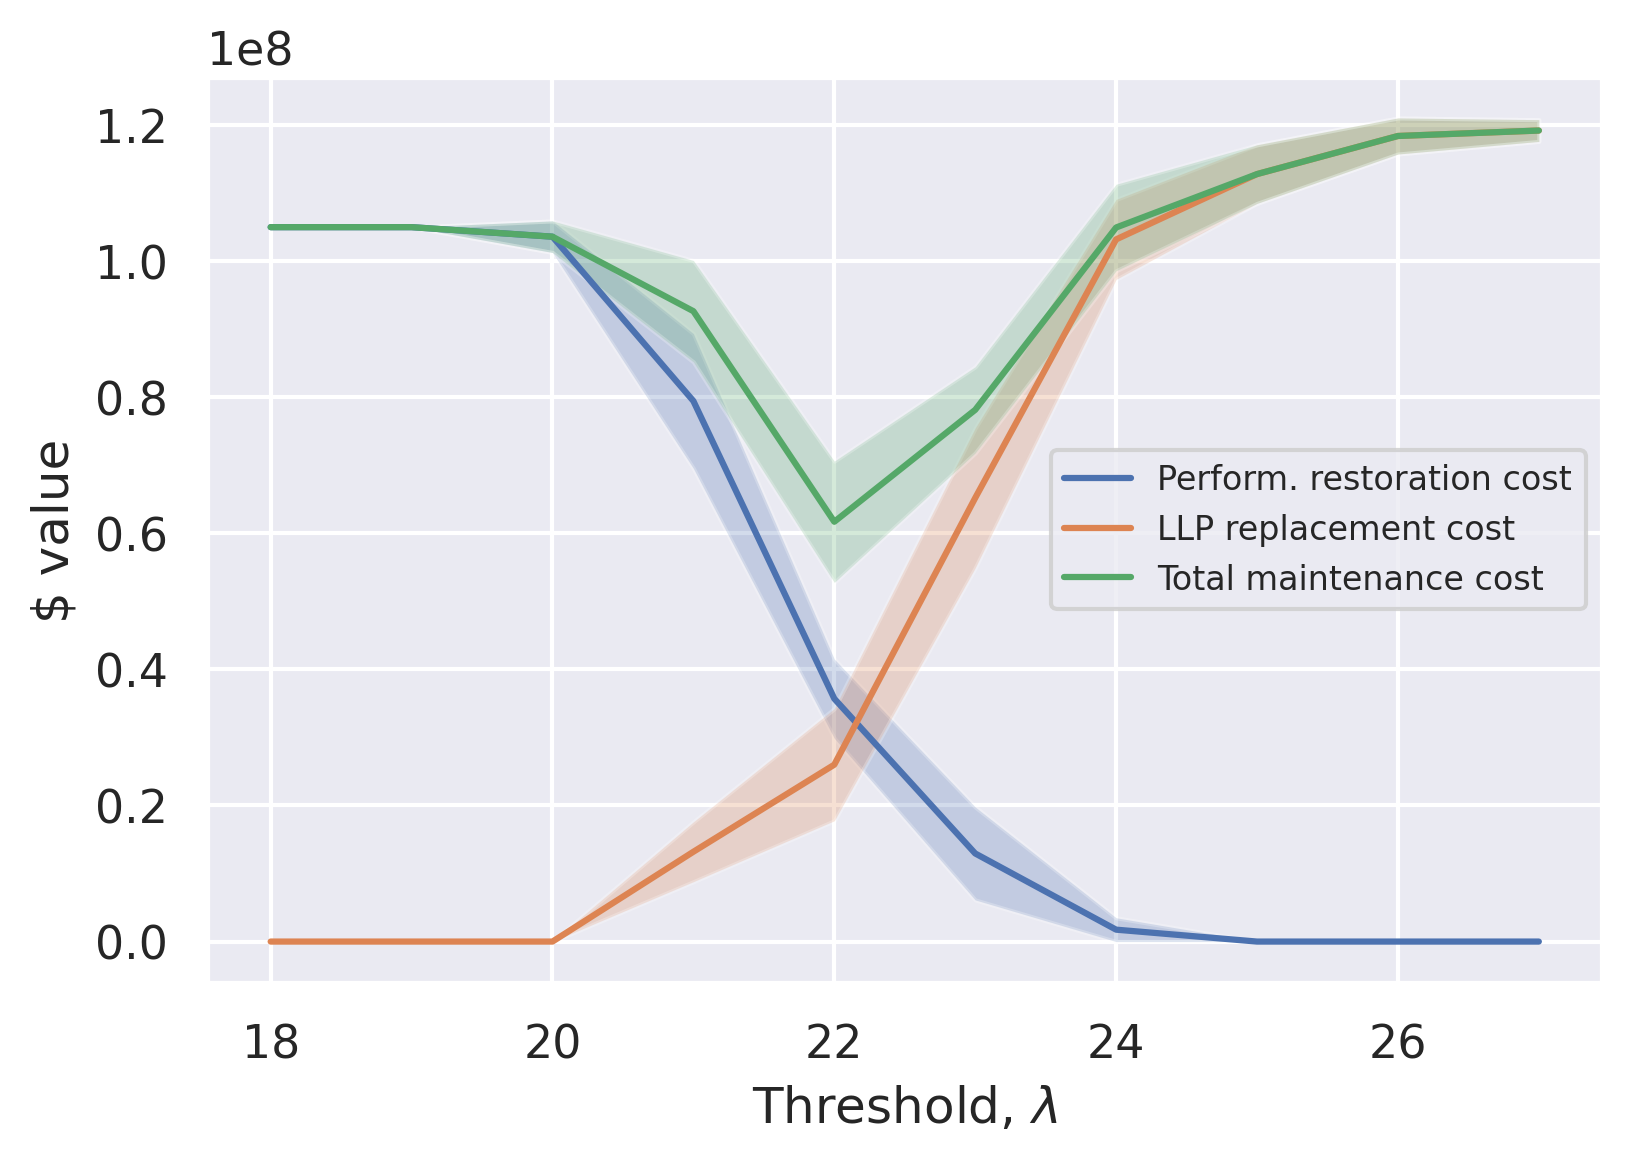

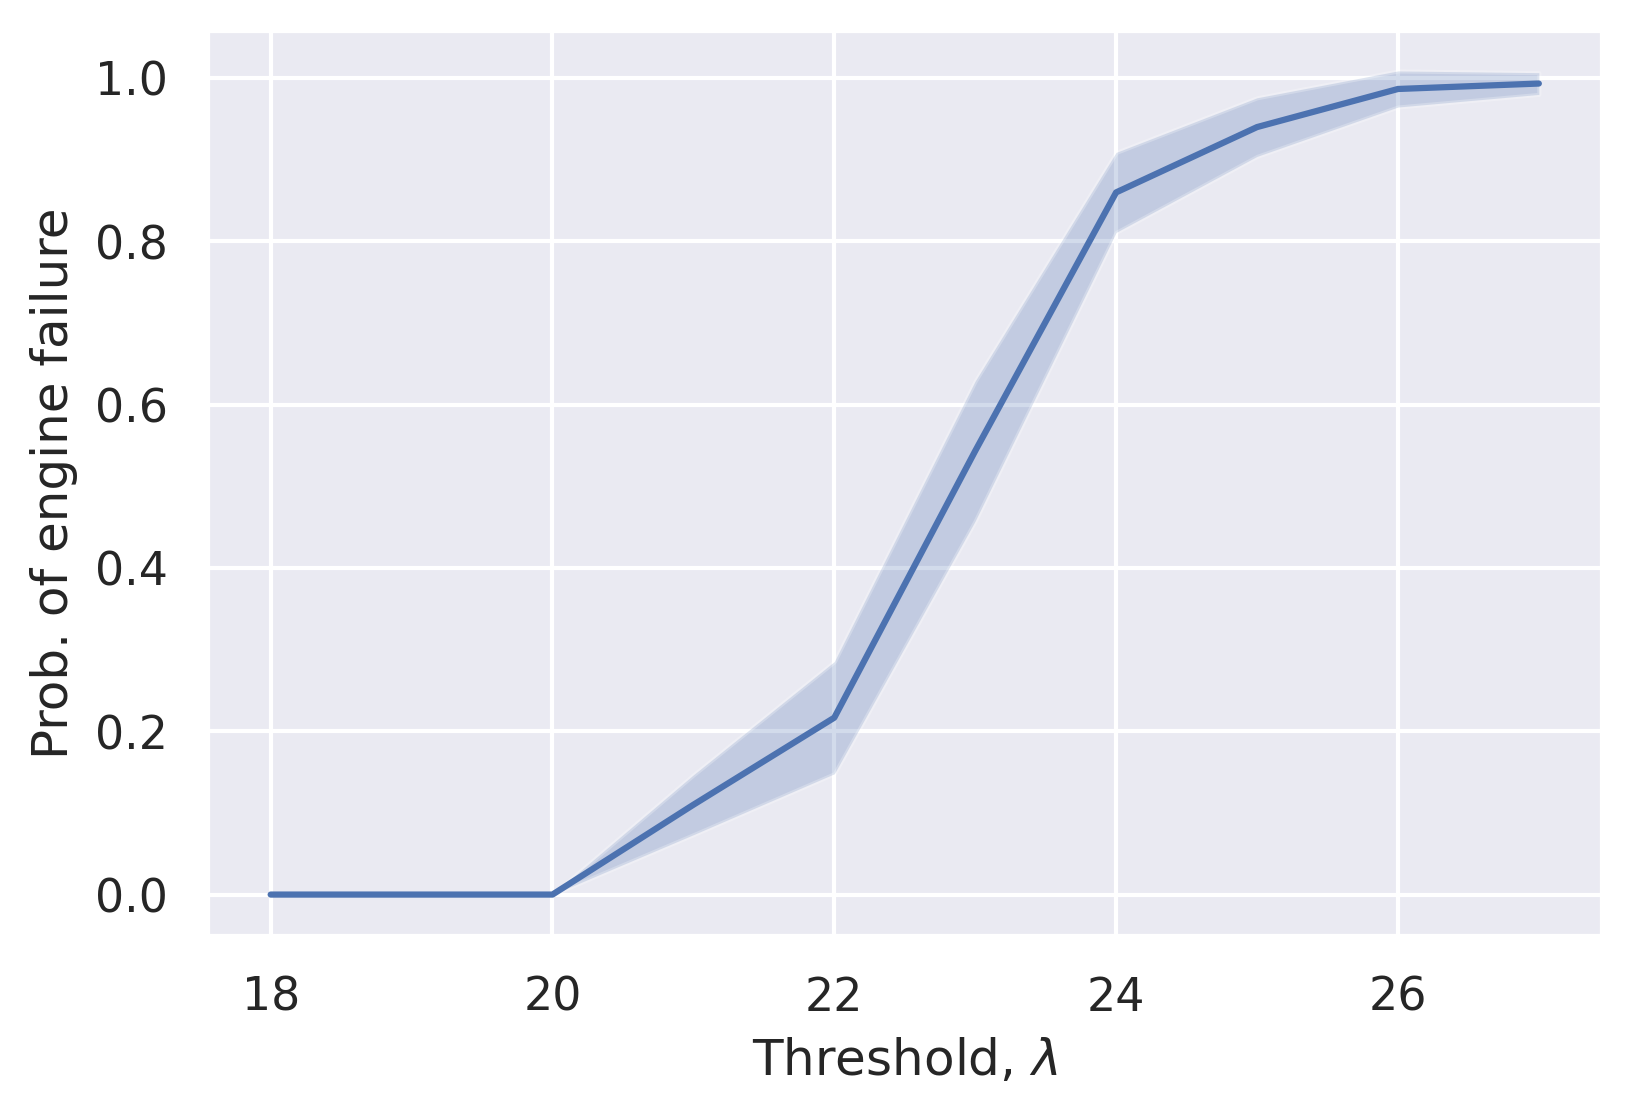

In [13]:
np.save('fd003_mean_', np.array(optim_data_mean))
np.save('fd003_std', np.array(optim_data_std))


mean_ = pd.DataFrame(np.array(optim_data_mean), columns=['thres', 'fail_prob', 'perf_rest', 'llp_rep', 'maint_cost'])
std_ = pd.DataFrame(np.array(optim_data_std), columns=['thres', 'fail_prob', 'perf_rest', 'llp_rep', 'maint_cost'])#

opt_thres_idx = mean_['maint_cost'].argmin()
opt_thres = thres_list[opt_thres_idx]

plt.figure(dpi=300)

plt.plot(thres_list, mean_['perf_rest'], label='Perform. restoration cost')
plt.fill_between(thres_list, mean_['perf_rest'] -std_['perf_rest'],  
                 mean_['perf_rest'] +std_['perf_rest'], alpha=0.25)

plt.plot(thres_list, mean_['llp_rep'], label='LLP replacement cost')
plt.fill_between(thres_list, mean_['llp_rep'] -std_['llp_rep'],  
                 mean_['llp_rep'] +std_['llp_rep'], alpha=0.25)

plt.plot(thres_list, mean_['maint_cost'], label='Total maintenance cost')
plt.fill_between(thres_list, mean_['maint_cost'] -std_['maint_cost'],  
                 mean_['maint_cost'] +std_['maint_cost'], alpha=0.25)

plt.xlabel('Threshold, $\lambda$')
plt.ylabel('$ value')
plt.legend( fontsize=8)
plt.savefig('fd003_cost.pdf', format='pdf')
plt.show()

plt.figure(dpi=300)
plt.plot(thres_list, mean_['fail_prob'], label='Engine failure probability')
plt.fill_between(thres_list, mean_['fail_prob'] -std_['fail_prob'],  
                 mean_['fail_prob'] +std_['fail_prob'], alpha=0.25)
plt.xlabel('Threshold, $\lambda$')
plt.ylabel('Prob. of engine failure')
plt.savefig('fd003_prob.pdf', format='pdf')
plt.show()


In [14]:
mean_

,thres,fail_prob,perf_rest,llp_rep,maint_cost
0,18.0,0.000000,105000000.0,0.0,105000000.0
1,19.0,0.000000,105000000.0,0.0,105000000.0
2,20.0,0.000000,103600000.0,0.0,103600000.0
3,21.0,0.110000,79450000.0,13200000.0,92650000.0
4,22.0,0.216667,35700000.0,26000000.0,61700000.0
5,23.0,0.543333,12950000.0,65200000.0,78150000.0
6,24.0,0.860000,1750000.0,103200000.0,104950000.0
7,25.0,0.940000,0.0,112800000.0,112800000.0
8,26.0,0.986667,0.0,118400000.0,118400000.0
9,27.0,0.993333,0.0,119200000.0,119200000.0


### Testing [We'll ignore this for now and focus on using training set]

In [15]:
#testing

machine_test_i = []
thres = opt_thres
for i in trange(X_test['UnitNumber'].max()):
      X_sub = X_test.loc[X_test['UnitNumber'] == i+1]
      X_fail = X_test.loc[X_test['UnitNumber'] == i+1]['IsFailure']      
      predictions = cph.predict_partial_hazard(X_sub[pred_cols])

      m_maint = np.log(predictions) > thres 
      
      total_perf_rest = (m_maint.sum()>1) * perf_restoration      
      is_failed = m_maint.sum()==0
      total_llp_rep = is_failed*llp_replacement      
      total_maintcost = total_perf_rest + total_llp_rep      
      machine_test_i.append([thres, is_failed, total_perf_rest, total_llp_rep, total_maintcost])

In [16]:
opt_thres

22

In [17]:
result_test = pd.DataFrame(np.array(machine_test_i), columns=['thres', 'is_failed', 'perf_rest', 'llp_rep', 'maint_cost'])
result_thres_test = result_test.groupby('thres').sum().reset_index()
result_thres_test['is_failed'] = result_thres_test['is_failed']/X_test['UnitNumber'].max()
result_thres_test


,thres,is_failed,perf_rest,llp_rep,maint_cost
0,22,1.0,0,400000000,400000000


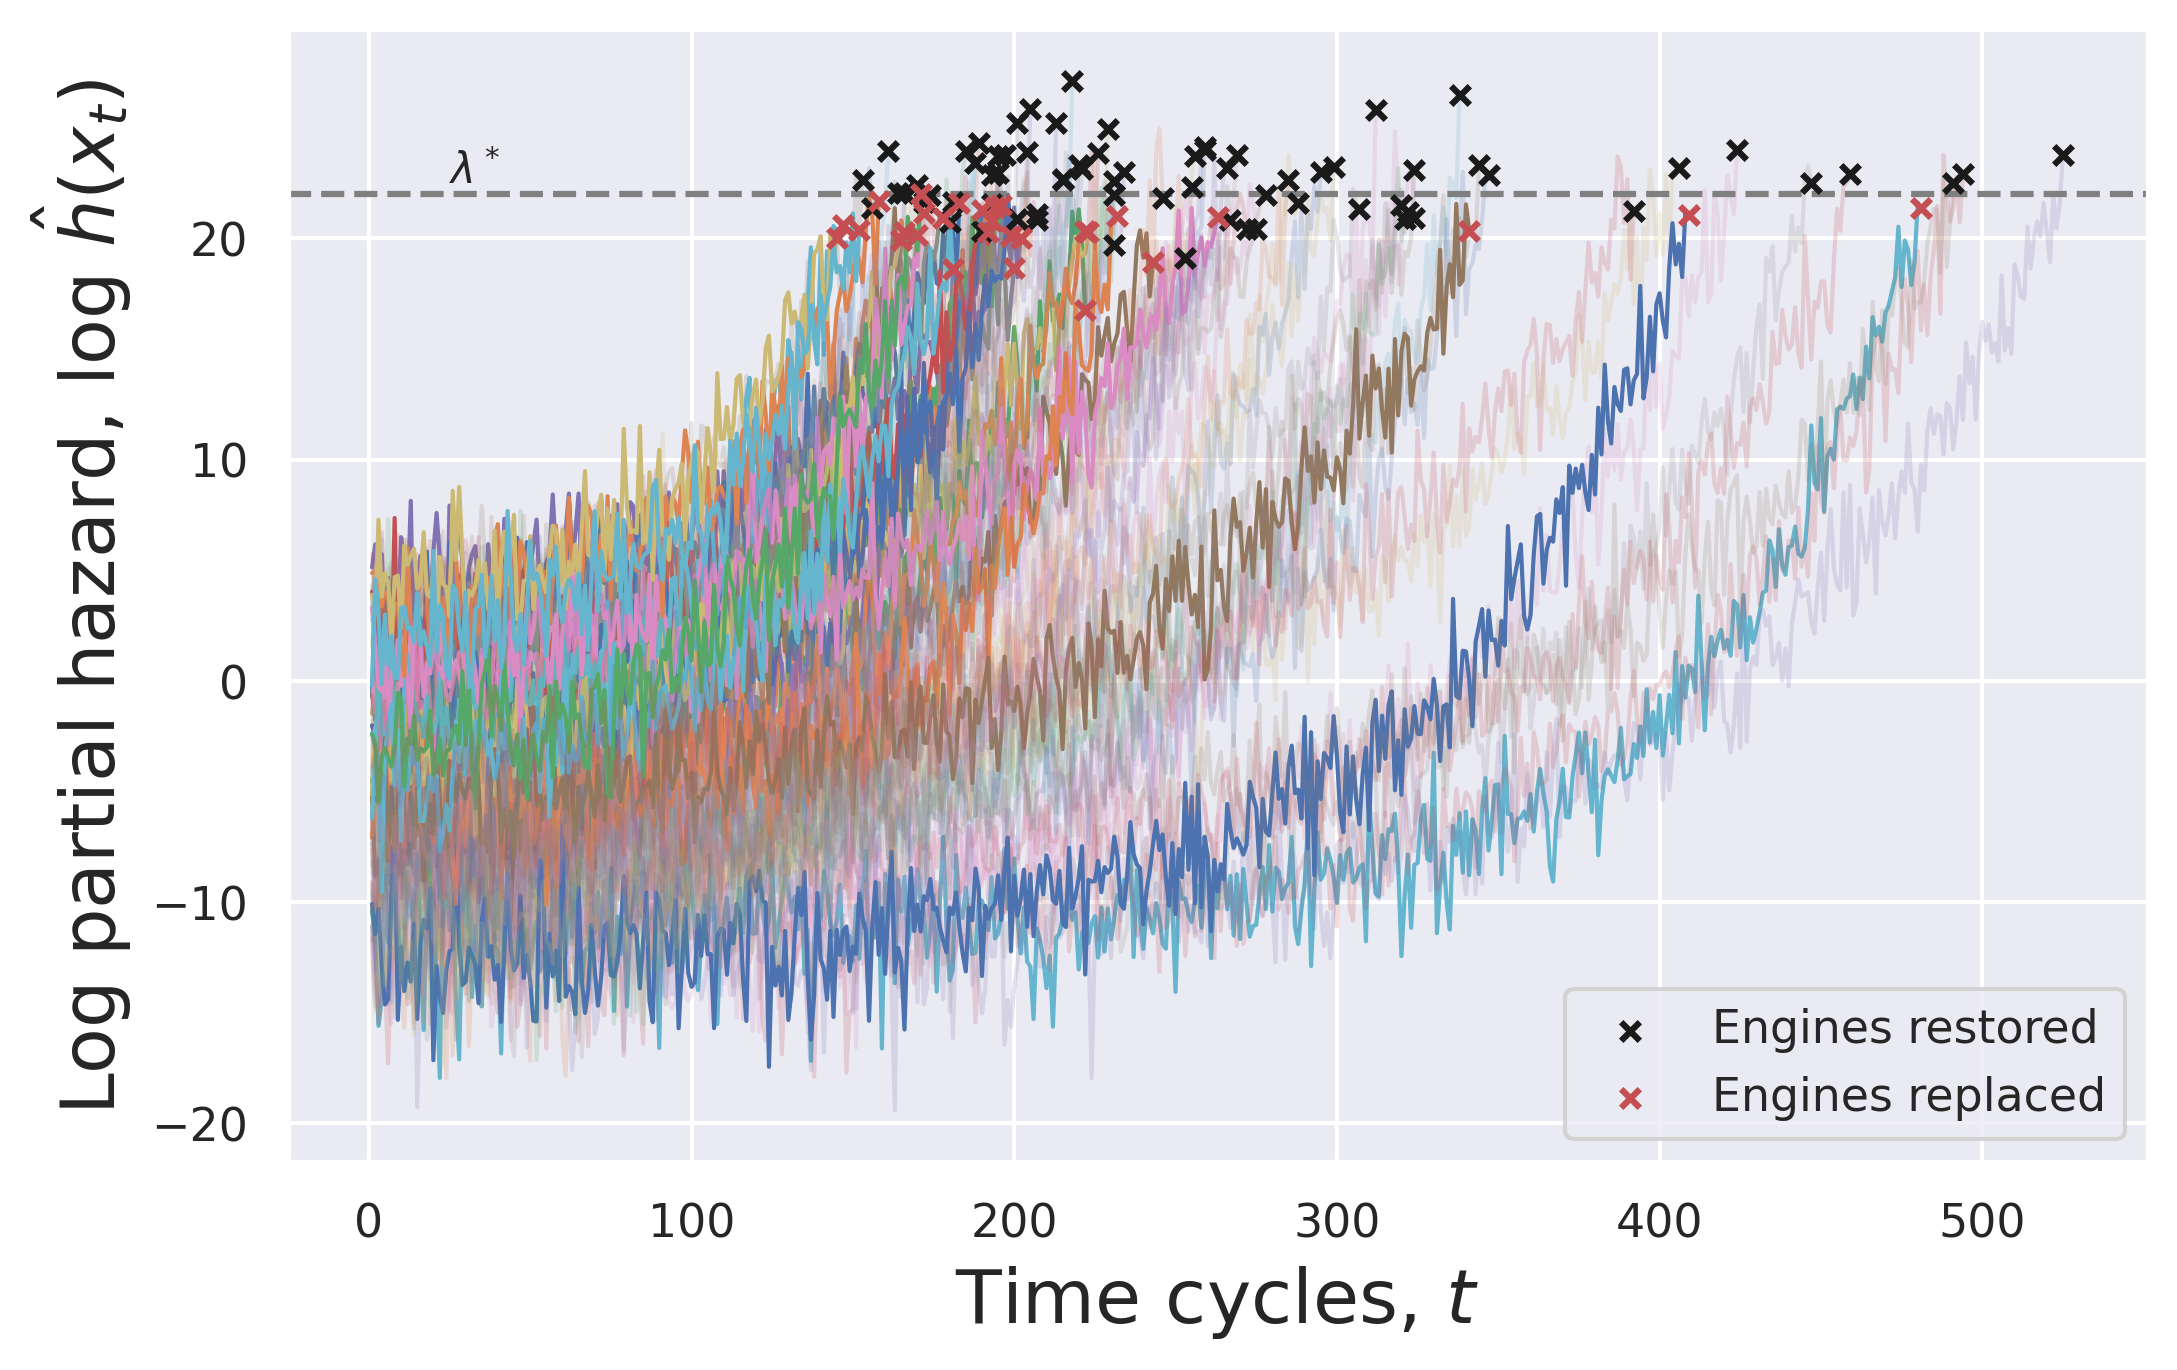

In [18]:
plt.figure(figsize=(8,5), dpi=300)
df_X = X
engines_restored = []
engines_replaced = []
for i in trange(100):
    X_sub = df_X.loc[df_X['UnitNumber'] == i+1]
    predictions = cph.predict_partial_hazard(X_sub[pred_cols])
    log_partial_hazard = np.log(predictions)
    is_maintained = log_partial_hazard.max() > thres
    plt.plot(X_sub['Cycle'].values, log_partial_hazard, alpha=0.2+0.8*~is_maintained, lw=1)
        
    if is_maintained:
      engines_restored.append([np.array(X_sub['Cycle'].values)[-1], np.log(predictions).values[-1]])      
    else:
      engines_replaced.append([np.array(X_sub['Cycle'].values)[-1], np.log(predictions).values[-1]])
engines_restored = np.array(engines_restored)
engines_replaced = np.array(engines_replaced)      

if len(engines_restored) > 0:
  plt.scatter(engines_restored[:, 0], engines_restored[:, 1], s=20, marker="x", zorder=10, c="k", label="Engines restored")  
if len(engines_replaced) > 0:
  plt.scatter(engines_replaced[:, 0], engines_replaced[:, 1], s=20, marker="x", zorder=10, c="r", label="Engines replaced")


plt.xlabel('Time cycles, $t$', fontsize=18)
plt.ylabel('Log partial hazard, $\log ~\hat{h}(x_t)$', fontsize=18)
plt.text(25, thres+0.5, '$\lambda^*$')
plt.legend()
plt.axhline(thres, c='gray', linestyle="dashed")
plt.savefig('sim_result_fd003.pdf',format="pdf")
plt.show()